In [10]:
import sys
sys.path.append("../../")
import numpy as np
from DanceProj1.XGB_Genreclass import get_XGBclassifier
from DanceProj1.DanceObj import Dance
from DanceProj1.data_proc import get_data
import matplotlib.pyplot as plt

In [11]:
testset, xgb_mod, y_pred, yprobdf = get_XGBclassifier()

In [12]:
yprobdf.head()

,Ballet Jazz,Break,House,Krump,LAhop,Lock,Midhop,Pop,Street Jazz,Waack,Original Index,True_Label,id
0,0.797785,0.040908,0.001779,0.004911,0.005451,0.003255,0.133834,0.003016,0.005253,0.003808,1605,Ballet Jazz,gJB_sFM_cAll_d08_mJB4_ch12
1,0.749671,0.009447,0.000601,0.228879,0.001360,0.002353,0.002952,0.001165,0.001547,0.002026,1593,Ballet Jazz,gJB_sFM_cAll_d08_mJB5_ch13
2,0.994203,0.000465,0.000155,0.000498,0.000235,0.002928,0.000178,0.000167,0.000904,0.000268,1581,Ballet Jazz,gJB_sFM_cAll_d09_mJB1_ch16
3,0.728855,0.163679,0.004542,0.006676,0.005476,0.003970,0.074837,0.002170,0.006211,0.003584,1611,Ballet Jazz,gJB_sFM_cAll_d08_mJB2_ch10
4,0.026114,0.053793,0.009651,0.033276,0.077352,0.722938,0.008733,0.011194,0.021872,0.035076,1609,Ballet Jazz,gJB_sFM_cAll_d09_mJB2_ch17


In [13]:
#split into dfs by genre
BJazzdf = yprobdf[yprobdf['True_Label']=='Ballet Jazz']
Breakdf = yprobdf[yprobdf['True_Label']=='Break']
Housedf = yprobdf[yprobdf['True_Label']=='House']
Krumpdf = yprobdf[yprobdf['True_Label']=='Krump']
LAhopdf = yprobdf[yprobdf['True_Label']=='LAhop']
Lockdf = yprobdf[yprobdf['True_Label']=='Lock']
Midhopdf = yprobdf[yprobdf['True_Label']=='Midhop']
Popdf = yprobdf[yprobdf['True_Label']=='Pop']
SJazzdf = yprobdf[yprobdf['True_Label']=='Street Jazz']
Waackdf = yprobdf[yprobdf['True_Label']=='Waack']

Genredfs = [BJazzdf, Breakdf, Housedf, Krumpdf, LAhopdf, Lockdf, Midhopdf, Popdf, SJazzdf, Waackdf]

In [14]:
#inspect the misclassified Ballet Jazz pieces
yprob_misBJazz = BJazzdf[BJazzdf['Ballet Jazz']<0.5]
yprob_misBJazz

,Ballet Jazz,Break,House,Krump,LAhop,Lock,Midhop,Pop,Street Jazz,Waack,Original Index,True_Label,id
4,0.026114,0.053793,0.009651,0.033276,0.077352,0.722938,0.008733,0.011194,0.021872,0.035076,1609,Ballet Jazz,gJB_sFM_cAll_d09_mJB2_ch17
7,0.272156,0.061449,0.006687,0.131092,0.043541,0.186638,0.003256,0.011460,0.251545,0.032176,1583,Ballet Jazz,gJB_sFM_cAll_d07_mJB4_ch05
8,0.248956,0.177737,0.117325,0.043570,0.113197,0.148185,0.032099,0.021178,0.073220,0.024533,1579,Ballet Jazz,gJB_sFM_cAll_d08_mJB3_ch11
9,0.372033,0.592090,0.002234,0.004698,0.005930,0.001558,0.010211,0.002272,0.006777,0.002197,1587,Ballet Jazz,gJB_sFM_cAll_d08_mJB1_ch09


In [15]:
aistpath = '../../aist_keypoints'      #path to 3d keypoints data
dataBM, dataFM = get_data(aistpath)    #get data
dataFM['Ballet Jazz'][0][-1]

'gJB_sFM_cAll_d07_mJB3_ch04'

In [19]:
#get Dance object for Ballet Jazz pieces that were correctly classified
HitBJazz = []
for data in dataFM['Ballet Jazz']:
    if data[-1] in BJazzdf[BJazzdf['Ballet Jazz']>0.5].values:
        HitBJazz.append(Dance(data[0],dt=1/60))
        HitBJazz[-1].get_features()

print(len(HitBJazz)) 

6


In [16]:
#get Dance object for all Ballet Jazz pieces that were misclassified
missBJazz = []
for data in dataFM['Ballet Jazz']:
    if data[-1] in yprob_misBJazz.id.values:
        print(data[-1])
        missBJazz.append(Dance(data[0], dt=1/60))
        missBJazz[-1].get_features()

print(len(missBJazz))
print(missBJazz[0])
print(missBJazz[0].acceleration.shape)

gJB_sFM_cAll_d08_mJB3_ch11
gJB_sFM_cAll_d07_mJB4_ch05
gJB_sFM_cAll_d08_mJB1_ch09
gJB_sFM_cAll_d09_mJB2_ch17
4
(15, 2093, 3)


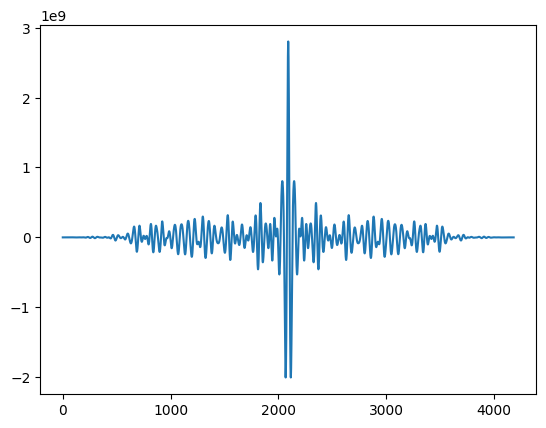

In [17]:
#get and plot autocorrelation of jerk for ankles, y dimension, of first misclassified Ballet Jazz piece
anklecorry_jer = (np.correlate(missBJazz[0].jerk[13][:,1], missBJazz[0].jerk[13][:,1], mode='full') + 
             np.correlate(missBJazz[0].jerk[14][:,1], missBJazz[0].jerk[14][:,1], mode='full')) / 2

plt.plot(anklecorry_jer)

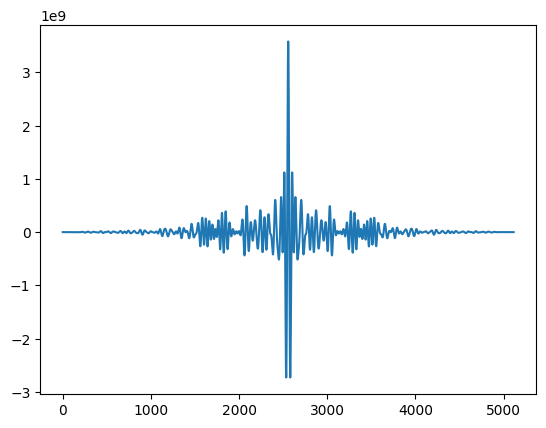

In [20]:
#get and plot autocorrelation of jerk for ankles, y dimension, of first correctly classified Ballet Jazz piece
anklecorry_jer = (np.correlate(HitBJazz[0].jerk[13][:,1], HitBJazz[0].jerk[13][:,1], mode='full') + 
             np.correlate(HitBJazz[0].jerk[14][:,1], HitBJazz[0].jerk[14][:,1], mode='full')) / 2

plt.plot(anklecorry_jer)

In [25]:
#look at the features of the misclassified Ballet Jazz pieces
testset.loc[testset.id.isin(yprob_misBJazz.id)]

,Expandedness,Expandedness_std,Expandednessvel,Expandednessvel_std,Expandednessacc,Expandednessacc_std,Asym_RL_vel,Asym_RL_acc,Asym_RL_jer,Asym_RL_vel_std,...,Contracorr_Relb_Lknee_prominencej2,Contracorr_Relb_Lknee_prominencej3,Contracorr_Relb_Lknee_prominencej_std,Contracorr_Lelb_Rknee_heightjer,Contracorr_Lelb_Rknee_prominencej1,Contracorr_Lelb_Rknee_prominencej2,Contracorr_Lelb_Rknee_prominencej3,Contracorr_Lelb_Rknee_prominencej_std,id,Genre
1609,952.230629,103.339482,1173.811693,590.516327,5529.458983,2822.475105,-3101.460326,-3842.680385,-18763.210259,13.561335,...,7.749144e+08,6.417610e+08,3.189269e+08,1.187765e+08,9.508543e+08,7.796116e+08,6.957601e+08,1.061593e+08,gJB_sFM_cAll_d09_mJB2_ch17,Ballet Jazz
1583,986.565303,106.354552,1250.544711,716.203115,6256.392835,3838.150549,979.998271,-8376.755982,7664.762826,5.987970,...,1.379766e+09,9.206970e+08,3.159570e+08,6.021521e+08,1.457539e+09,1.285451e+09,1.222143e+09,9.946194e+07,gJB_sFM_cAll_d07_mJB4_ch05,Ballet Jazz
1579,1016.357632,99.647915,1285.371478,587.623914,5784.954412,2807.437497,2195.687077,1578.601247,1954.705135,6.754464,...,9.035397e+08,7.964862e+08,8.472218e+07,1.002533e+09,1.734618e+09,1.686987e+09,1.495129e+09,1.035124e+08,gJB_sFM_cAll_d08_mJB3_ch11,Ballet Jazz
1587,1048.961981,107.692128,1234.471461,737.767102,5619.424194,3698.488138,9465.520424,-1080.890634,1052.127688,34.725294,...,1.543689e+09,1.448671e+09,5.126360e+07,4.751784e+08,1.018493e+09,8.528029e+08,7.857072e+08,9.783448e+07,gJB_sFM_cAll_d08_mJB1_ch09,Ballet Jazz
